<a href="https://colab.research.google.com/github/BBotond03/SkinCancerDetection/blob/main/main_transfer_2_oversampling_1_ipynb_m_solata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Script for Downloading the Data
1. We download the data  through the Kaggle API (for this we will have to provide out personal API key, this can be found at Kaggle profile settings).
2. Extract the downloaded zip file

In [2]:
#to be able to download the dataset to our current runtime
!pip install kaggle

In [3]:
from google.colab import files

# Upload the file
uploaded = files.upload()

# Get the actual file name from the dictionary
file_name = list(uploaded.keys())[0]
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Save the API key securely without displaying it
with open('/root/.kaggle/kaggle.json', 'wb') as f:
    f.write(uploaded[file_name])

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json


Saving kaggle (3).json to kaggle (3).json
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
!kaggle competitions download -c isic-2024-challenge

100% 2.00G/2.00G [01:33<00:00, 24.0MB/s]
100% 2.00G/2.00G [01:33<00:00, 22.9MB/s]


In [5]:
import zipfile
import os

# Path to your zip file and extract location
zip_file_path = 'isic-2024-challenge.zip'
extract_to_path = 'data'

# Extracting the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)
    print("Extraction completed.")

Extraction completed.


# Data Preproccessing

In [6]:
!pip install tensorflow

In [7]:
#neccesary imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow_datasets as tfds
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample


In [15]:
import os
import pandas as pd
import cv2
import albumentations as A
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.utils import resample

# Load CSV
csv_path = './data/train-metadata.csv'
df = pd.read_csv(csv_path, low_memory=False)

# Append '.jpg' to each isic_id to match image filenames
df['isic_id'] = df['isic_id'].astype(str) + '.jpg'

# Directory where images are stored
img_dir = './data/train-image/image'  # Ensure this path is correct

# Filter for files that actually exist
df['filepath'] = df['isic_id'].apply(lambda x: os.path.join(img_dir, x))
df = df[df['filepath'].apply(os.path.exists)]

# Print out a summary
print(f"Number of valid images after filtering: {len(df)}")
print(df[['isic_id', 'filepath']].head())  # Optional: to verify paths

# Convert `target` to string for binary classification
df['target'] = df['target'].astype(str)

# Define Albumentations augmentation pipeline
augment = A.Compose([
    A.Rotate(limit=15, p=0.5),  # Rotate within ±15 degrees, 50% chance
    A.RandomResizedCrop(height=150, width=150, scale=(0.8, 1.0), p=0.5),  # Zoom
    A.HorizontalFlip(p=0.5),  # Optional: Horizontal flip
], additional_targets={'image': 'image'})

def augment_image(filepath):
    """
    Reads an image, applies Albumentations transformations, and returns the augmented image.
    """
    try:
        image = cv2.imread(filepath)
        if image is None:
            raise ValueError(f"Image not found or invalid: {filepath}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        augmented = augment(image=image)['image']
        return augmented
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        # Return a blank image of expected shape as a fallback
        return np.zeros((150, 150, 3), dtype=np.uint8)

# Undersample the majority class to balance the dataset
df_majority = df[df['target'] == '0']  # Class A
df_minority = df[df['target'] == '1']  # Class B
minority_class_size = len(df_minority)
df_majority_undersampled = df_majority.sample(
    n=minority_class_size,  # Match the minority class size
    random_state=42         # Set random state for reproducibility
)
df_balanced = pd.concat([df_majority_undersampled, df_minority]).sample(frac=1, random_state=42).reset_index(drop=True)

# Define DataFrame generator with Albumentations
def data_generator(df, batch_size, augment_fn):
    """
    Custom generator that applies Albumentations augmentations.
    """
    while True:
        df = df.sample(frac=1).reset_index(drop=True)  # Shuffle dataset
        for i in range(0, len(df), batch_size):
            batch = df.iloc[i:i + batch_size]
            images = []
            labels = []
            for filepath, label in zip(batch['filepath'], batch['target']):
                try:
                    augmented_image = augment_fn(filepath)
                    # Ensure the image has the correct shape
                    augmented_image = cv2.resize(augmented_image, (150, 150))  # Force shape
                    images.append(augmented_image)
                    labels.append(float(label))
                except Exception as e:
                    print(f"Error processing {filepath}: {e}")
                    # Append fallback values in case of an error
                    images.append(np.zeros((150, 150, 3), dtype=np.uint8))
                    labels.append(0.0)
            # Convert to NumPy arrays
            images = np.array(images, dtype=np.float32) / 255.0  # Normalize images
            labels = np.array(labels, dtype=np.float32)
            yield images, labels
# Define dataset
batch_size = 32
train_size = int(len(df_balanced) * 0.8)  # 80% for training
train_df = df_balanced[:train_size]
val_df = df_balanced[train_size:]

train_gen = data_generator(train_df, batch_size, augment_image)
val_gen = data_generator(val_df, batch_size, augment_image)

# Wrap generators into TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
).repeat()

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

# Calculate steps per epoch
train_steps_per_epoch = len(train_df) // batch_size
val_steps_per_epoch = len(val_df) // batch_size

print(f"Train steps per epoch: {train_steps_per_epoch}")
print(f"Validation steps per epoch: {val_steps_per_epoch}")


Number of valid images after filtering: 401059
            isic_id                                   filepath
0  ISIC_0015670.jpg  ./data/train-image/image/ISIC_0015670.jpg
1  ISIC_0015845.jpg  ./data/train-image/image/ISIC_0015845.jpg
2  ISIC_0015864.jpg  ./data/train-image/image/ISIC_0015864.jpg
3  ISIC_0015902.jpg  ./data/train-image/image/ISIC_0015902.jpg
4  ISIC_0024200.jpg  ./data/train-image/image/ISIC_0024200.jpg
Train steps per epoch: 19
Validation steps per epoch: 4


In [16]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.utils import class_weight
import numpy as np


In [20]:

# Define image size and batch size
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 50

# Initialize the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # Freeze base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)  # Add a second dense layer: 128,
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Calculate class weights
labels = df['target'].astype(int).values  # Ensure target values are integers (0 or 1)




# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(
    filepath='best_melanoma_inceptionv3.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-7
)


# Train the model with class weights and callbacks
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps_per_epoch,  # Use calculated steps_per_epoch
    validation_steps=val_steps_per_epoch,  # Use calculated validation_steps
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],

)

# Unfreeze some layers for fine-tuning
base_model.trainable = True
fine_tune_at = 249

# Freeze the layers before `fine_tune_at`
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS // 2,
    steps_per_epoch=train_steps_per_epoch,  # Reusing pre-computed steps_per_epoch
    validation_steps=val_steps_per_epoch,  # Reusing pre-computed validation_steps
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
)

# Load the best saved model
best_model = tf.keras.models.load_model('best_melanoma_inceptionv3.keras')

# Evaluate the best model on the validation set
loss, accuracy = best_model.evaluate(val_dataset, steps=val_steps_per_epoch)
print(f"Best Model Validation Accuracy: {accuracy:.2f}")

tensorboard_callback = TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=1)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_282 (Conv2D)       │ (None, 74, 74, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_282   │ (None, 74, 74, 32)     │             96 │ conv2d_282[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_282            │ (None, 74, 74, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_283 (Conv2D)       │ (None, 72, 72, 32)     │          9,216 │ activation_282[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_283   │ (None, 72, 72, 32)     │             96 │ conv2d_283[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_283            │ (None, 72, 72, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_284 (Conv2D)       │ (None, 72, 72, 64)     │         18,432 │ activation_283[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_284   │ (None, 72, 72, 64)     │            192 │ conv2d_284[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_284            │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 35, 35, 64)     │              0 │ activation_284[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_285 (Conv2D)       │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_285   │ (None, 35, 35, 80)     │            240 │ conv2d_285[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_285            │ (None, 35, 35, 80)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_286 (Conv2D)  

 Total params: 23,115,297 (88.18 MB)

 Trainable params: 1,312,513 (5.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.4837 - loss: 0.7507
Epoch 1: val_loss improved from inf to 0.67643, saving model to best_melanoma_inceptionv3.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.4838 - loss: 0.7488 - val_accuracy: 0.5000 - val_loss: 0.6764 - learning_rate: 1.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5154 - loss: 0.6945
Epoch 2: val_loss improved from 0.67643 to 0.65764, saving model to best_melanoma_inceptionv3.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.5155 - loss: 0.6944 - val_accuracy: 0.6719 - val_loss: 0.6576 - learning_rate: 1.0000e-04
Epoch 3/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5592 - loss: 0.6893
Epoch 3: val_loss improved from 0.65764 to 0.64249, saving model to best_melanoma_inceptionv3.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.5582 - loss: 0.6896 - val_accuracy: 0.6984 - val_loss: 0.6425 - learning_rate: 1.0000e-04
Epoch 4/50
18/1

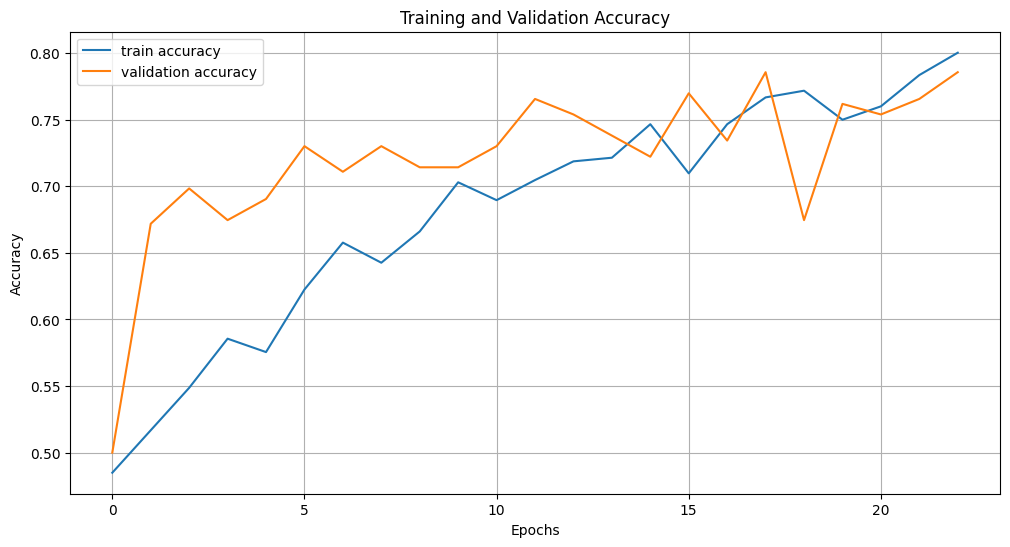

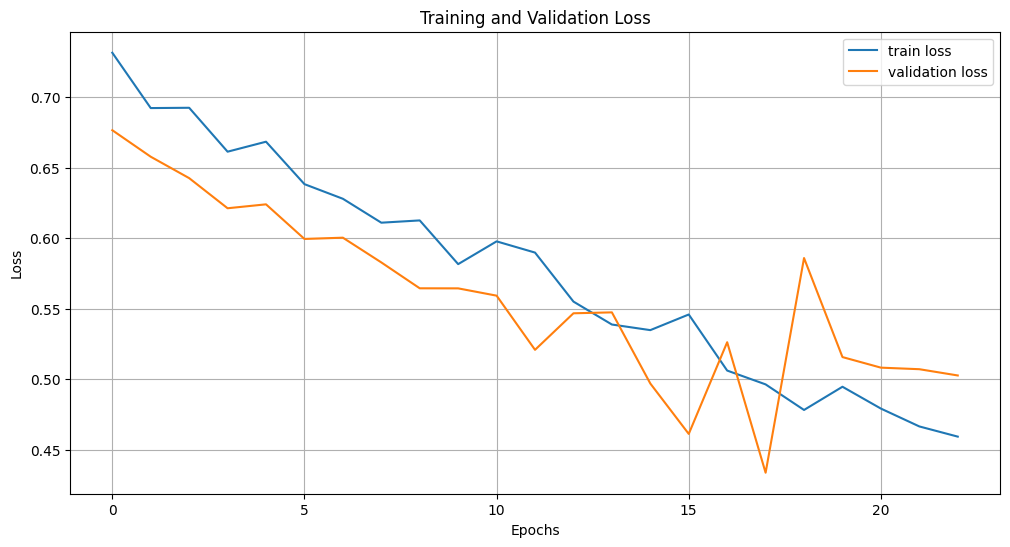

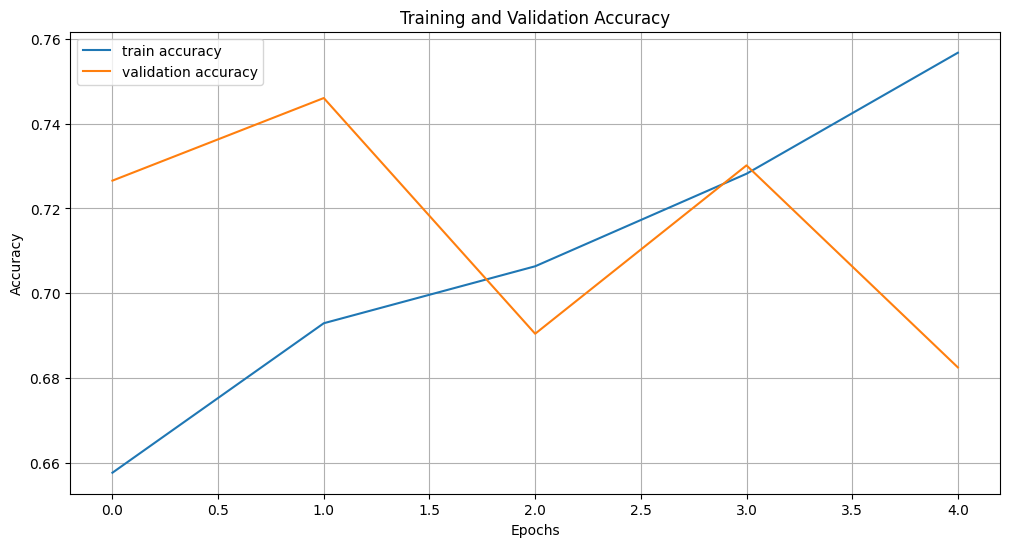

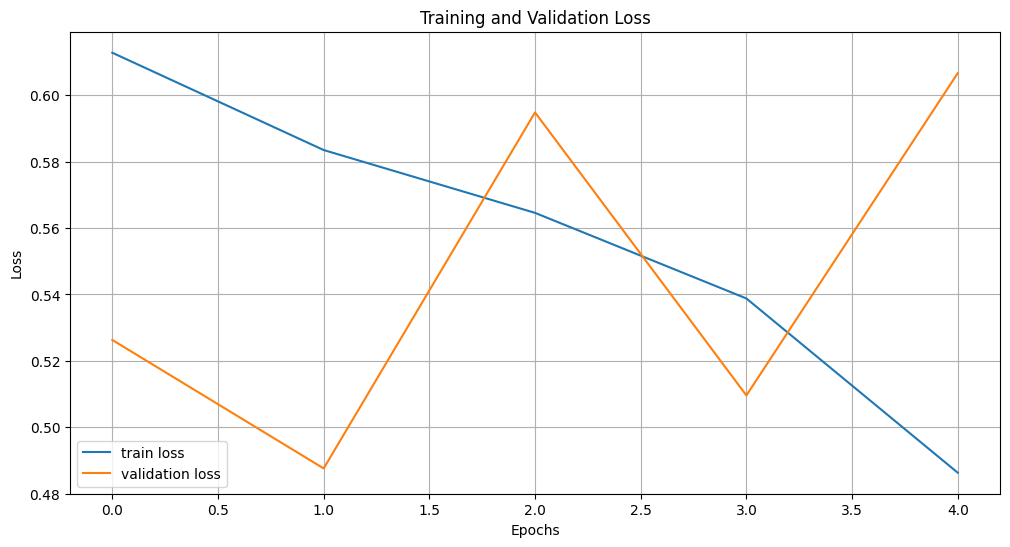

In [21]:
import matplotlib.pyplot as plt

def plot_training(history):
    # Plot training accuracy and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.grid(True)
    plt.show()

    # Plot training loss and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.grid(True)
    plt.show()

# Assuming `history` is the history of your initial model training
# and `history_fine` is the history after fine-tuning

plot_training(history)  # Plot for the initial training
plot_training(history_fine)  # Plot for the fine-tuned model


In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# Assuming `val_gen` is your validation generator and `model` is your trained model
# Make predictions on the validation data
y_pred_prob = model.predict(val_gen)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()  # Threshold at 0.5 for binary classification

# Get the true labels from the validation generator
y_true = np.concatenate([y for x, y in val_gen], axis=0).flatten()  # Flatten for compatibility

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(cm, display_labels=['Class 0', 'Class 1']).plot(cmap='Blues', ax=ax, colorbar=False)

# Add title and metrics to the plot
plt.title('Confusion Matrix with Metrics')
plt.xlabel(f'Predicted Labels\n\nPrecision: {precision:.2f} | Recall: {recall:.2f} | F1 Score: {f1:.2f}')
plt.ylabel('True Labels')
plt.show()



  18699/Unknown 649s 34ms/step

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Get the predicted probabilities
y_pred_prob = model.predict(val_gen).flatten()  # Flatten to a 1D array

# Get the true labels from the validation generator
y_true = np.concatenate([y for x, y in val_gen], axis=0).flatten()  # Flatten for compatibility

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_true, y_pred_prob)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



In [ ]:
# Visualize the network with keras visualizer
!pip3 install keras-visualizer
from keras_visualizer import visualizer
import matplotlib.image as mpimg
visualizer(model, file_format='png', view=True)
img = mpimg.imread('graph.png')
fig = plt.figure(figsize=[20,9])
plt.imshow(img)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs